# Modeling transmon qubit Cooper-pair box Hamiltonian in the charge basis 

(Zlatko Minev, Christopher Warren, Nick Lanzillo 2021)

This module models the transmon qubit in the cooper-pair charge basis, assuming wrapped junction phase variable. The Hamiltonian is given by: 

$$
\hat{H}=4E_{C}\left(\hat{n}-n_{g}\right)-E_{J}\cos\left(\hat{\phi}\right)\,,
$$

where $E_{C}$ is the charging energy, $E_{J}$ is the Josephson energy, $\hat n$ is the number of Cooper pairs transferred between charge islands, $\hat{\phi}$ is the gauge-invariant phase difference between charge islands, and $n_{g}$ is effective offset charge of the device. Expressions for the charging energy, Josephson energy and offset charge can be written as:

$$
E_{C}=\frac{e^{2}}{2C_{\Sigma}}\,,\qquad n_{g}=-\frac{C_{d}\dot{\Phi}_{s}\left(t\right)}{2e}\:,\qquad E_{J}=\frac{\phi_{0}^{2}}{L_{J}}\,,
$$

where $C_{\Sigma} = C_{J}+C_{B}+C_{g}$ (the sum of the Josephson capacitance, shunting capacitance and gate capacitance), $L_{J}$ is the inductance of the Josephson junction, and $\phi$ is the magnetic flux. 

The variables are
$$
\hat{\phi}\equiv\frac{\hat{\Phi}}{\phi_{0}},\qquad\hat{n}\equiv\frac{\hat{Q}}{2e}\,,
$$

Observe that $\hat \phi$ and $\hat n$ are both dimensiuonless, and they obey the commutation relationship:

$$
[\hat{\phi}, \hat{n}] = i
$$


The Hamiltonian can be written in the charge ($\hat n$) basis as: 

$$H=4E_\text{C}(\hat{n}-n_g)^2-\frac{1}{2}E_\text{J}\sum_n(|n\rangle\langle n+1|+\text{h.c.}),$$
Where $\hat{n} = \sum_{n=-\inf}^{\inf} |n\rangle\langle n|$

### Hcpb class

Hamiltonian-model Cooper pair box (Hcpb) class.

Used to model analytically the CPB Hamiltonian quickly
and efficiently. Solves in charge basis tridiagonal eigenvalue
problem for arbitrary Ej, Ec, ng values.

As long as nlevels remains fixed the number of charge states
considered does not change and it does not recreate the arrays,
just recomputes the properties

Returns all properties of interest for the CPB.

This model is closer to the analytic solution than the Duffing oscillator model.
Can work backwards from target qubit parameters to get the Ej, Ec or use
input Ej, Ec to find the spectrum of the Cooper Pair Box.

    @author: Christopher Warren (Chalmers University of Technology), updated by Zlatko K. Minev (IBM Quantum)
    @date: 2020, 2021




Let's start by importing the key modules for this demo: 

In [97]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy = True
%matplotlib inline
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'svg'

from qiskit_metal.analyses.hamiltonian.transmon_charge_basis import Hcpb
from qiskit_metal.analyses.hamiltonian.transmon_CPB_analytic import Hcpb_analytic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Let's model a transmon 

### Energy levels

We can get a feel for how to use the Hcpb class by plotting the first few eigenvalues as a function of offset charge, similar to the plots reported in Phys. Rev. A 76, 042319 (2007.) Let's start by defining the range of offset charge from -2.0 to +2.0 and also by defining a normalization for the eigenvalues, which will be the transition energy between the first two states evaluated at the degenercy point where ng=0.5. For this exercise, we'll take Josephson Energy to be equal to the charging energy:

In [98]:
x = np.linspace(-2.0,2.0,101) # this represents the charging energy (ng)
H_norm = Hcpb(nlevels=2, Ej=1000.0, Ec=1000.0, ng=0.5) # Hamiltonian definition 
norm = H_norm.fij(0,1) # normalization constant 

Next, we'll sweep over the offset charge and calculate the first three eigenvalues for a given value of ng. We'll need to define a new Hamiltonian for this. 

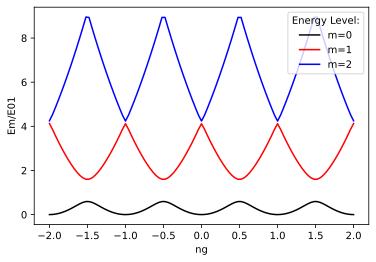

In [99]:
E0, E1, E2 = [], [], []

# For a given value of offset charge (ng, represented by x) we will calculate the CPB Hamiltonian using the previously assigned values of E_J and E_C. Then we calculate the eigenvalue for a given value of m.
for i in x: 
    H = Hcpb(nlevels=3, Ej=1000.0, Ec=1000.0, ng=i)
    E0.append(H.evalue_k(0)/norm)
    E1.append(H.evalue_k(1)/norm)
    E2.append(H.evalue_k(2)/norm)

# define the minimum of E0 and set this to E=0
floor = min(E0) 
 
plt.plot(x, E0 - floor, 'k', label="m=0")
plt.plot(x, E1 - floor, 'r', label="m=1")
plt.plot(x, E2 - floor, 'b', label="m=2")
plt.xlabel("ng")
plt.ylabel("Em/E01")
plt.legend(title="Energy Level:", loc='upper right')

### Comparing with the Analytic Expressions for Energy

We can compare calculated eigenvalues with the analytic solutions by using the "Hcpb_analytic" class, which calculates the transmon eigenvalues analytically using Mathieu characteristic values instead of a matrix-based approach. Let's compare the calculated values of the lowest energy at zero offset charge in both cases:  

In [100]:
# this is using the Hcpb approach as above, solving the charge basis tridiagonal eigenvalue problem:
H_CPB = Hcpb(nlevels=15, Ej=13971.3, Ec=295.2, ng=0.0)

# this using the Hcpb_analytic class, which solves using the exact (analytic) solutions in terms of Mathieu characteristic values: 
H_CPB_analytic = Hcpb_analytic(Ej=13971.3, Ec=295.2, ng=0.0)

# print and compare energies 
print("E0 (HCPB):", H_CPB.evalue_k(0))
print("E0 (HCPB analytic):", H_CPB_analytic.evalue_k(0))
print("Error:", 100*(H_CPB_analytic.evalue_k(0) - H_CPB.evalue_k(0)) / H_CPB_analytic.evalue_k(0))


E0 (HCPB): -11175.114908534233
E0 (HCPB analytic): -11175.114908534231
Error: -1.6277142726798518e-14


As we can see above, the calculated eigenvalues using the Hcbp class match the analytic values extremely well. 

### Wavefunctions 

Let's define a new Hamiltonian, this time with $E_{J} >> E_{C}$ and an offset charge of $ng=0.001$. We can calculate the transition energy between the lowest two states as well as the anharmonicity with the following: 

In [101]:
H = Hcpb(nlevels=3, Ej=13971.3, Ec=295.2, ng=0.001)
print(f"""
Transmon frequencies 

 ω01/2π = {H.fij(0,1): 6.0f} MHz
   α/2π = {H.anharm(): 6.0f} MHz
""")



Transmon frequencies 

 ω01/2π =   5604 MHz
   α/2π =     11 MHz



Note that both the transition energy and the anharmonicity are read out in units of Megahertz (MHz.) 

We can plot the eigenstates (wavefunctions) of the transmon qubit using the commands below: 

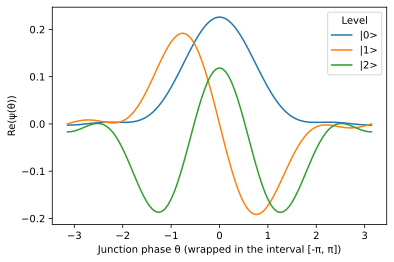

In [102]:
import matplotlib.pyplot as plt
for k in range (3):
    ψ, θ = H.psi_k(k,101)
    plt.plot(θ, ψ.real+ψ.imag, label=f"|{k}>") # it's in either quadrature, but not both
plt.xlabel("Junction phase θ (wrapped in the interval [-π, π])")
plt.ylabel("Re(ψ(θ))")
plt.legend(title="Level")

### Verifying Orthonormality of the Wavefunctions

Here, we can verify the orthonormality of the wavefunctions. Let's first take the first two eigenstates and verify that their inner product is zero, thereby confirming orthogonality. Note that since the wavefunctions can be complex, we need to take the complex conjugate of $\Psi1$. 

In [103]:
Psi0, theta0 = H.psi_k(0)
Psi1, theta1 = H.psi_k(1)
print(np.dot(Psi0,Psi1.conj()))

(-2.2354805733859444e-09-3.4875983780408155e-17j)


Indeed, we see that the dot product is essentially zero (within numerical precision.) Next, let's take the inner product of the first eigenstate with itself, checking that we get an output of unity:

In [104]:
print(np.dot(Psi0, Psi0.conj()))
print(np.dot(Psi1, Psi1.conj()))

(1+0j)
(1+0j)


Indeed we see that the dot products are essentially equal to unity, confirming that the states are appropriately normalized.  

# Additional Analysis: Charge Dispersion, Energy Level Differences and Anharmonicity

### Charge Dispersion

The peak-to-peak value of the charge dispersion for the mth energy level is given by the expression: $\epsilon_{m} = E_{m}(n_{g}=0.5) - E_{0}(n_{g}=0.0)$. We can plot $\epsilon_{m}/E_{01}$ as a function of $E_{J}/E_{C}$ for the first few energy levels and reproduce the figure published in Phys. Rev. A 76, 042319 (2007) (Figure 4(a)). 

We can start by defining a value of charging energy and creating empty lists for $\epsilon_{0}$ through $\epsilon_{4}$: 

In [105]:
E_c=100.0 # charging energy 
epsilon0, epsilon1, epsilon2, epsilon3 = [], [], [], []    # charge dispersion for m=0 through m=4
x = np.linspace(1,140,101)           # this this ratio of Ej/Ec which will go on the x-axis. 

Next, we simply evaluate the expression given above for $\epsilon_{m}$ based on $E_{m}$ and $E_{0}$. We use two separate Hamiltonians to do this; one evaluated at $n_{g}=0.5$ and one evaluated at $n_{g}=0.0$. We also normalize by the transition energy between the lowest two states evaluated at the degeneracy point ($E_{01}$.) Finally, we populate the lists each $\epsilon_{m}$. 

In [106]:
for i in x:
    E_j = i*E_c 
    H_zero = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.0)
    H_half = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    
    H_norm = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    norm = H_norm.fij(0,1)                         # normalization constant 
    
    epsilon0.append(abs(H_half.evalue_k(0) - H_zero.evalue_k(0))/norm)
    epsilon1.append(abs(H_half.evalue_k(1) - H_zero.evalue_k(1))/norm)
    epsilon2.append(abs(H_half.evalue_k(2) - H_zero.evalue_k(2))/norm)
    epsilon3.append(abs(H_half.evalue_k(3) - H_zero.evalue_k(3))/norm)

We can plot these values to see the exponential decrease in the charge dispersion with increasing $E_{J}/E_{C}$: 

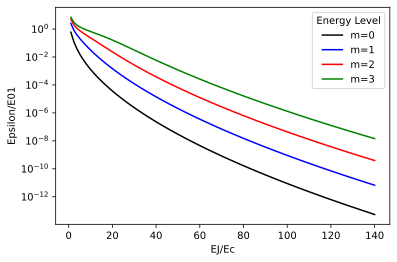

In [107]:
plt.plot(x, epsilon0, 'k', label="m=0")
plt.plot(x, epsilon1, 'b', label="m=1")
plt.plot(x, epsilon2, 'r', label="m=2")
plt.plot(x, epsilon3, 'g', label="m=3") 
plt.yscale("log")
plt.xlabel("EJ/Ec")
plt.ylabel("Epsilon/E01")
plt.legend(title="Energy Level", loc='upper right')

### Energy Level Differences

We can also evaluate the energy level difference ($E_{m0} = E_{m} - E_{0}$) evaluated at the degeneracy point ($n_{g}=0.5$) and compare to Fig. 4(b) of Phys. Rev. A 76, 042319 (2007). To do this, we just need to create empty lists for the energy levels ($E_{0}$ through $E_{3}$) as well as the energy level differences ($E_{00}$ through $E_{30}$.) 

In [108]:
E00, E10, E20, E30 = [], [], [], [] 
E0, E1, E2, E3 = [], [], [], [] 

Next, we'll sweep over $E_{J}/E_{C}$ from 0 to 140 (using the variable x defined above) and at each point, we'll construct the Hamiltonian and take the difference in eigenvalues evaluated at the degeneracy point $n_{g}=0.5$. We'll also normalize the energy level differences by the charging energy to be consistent with Fig. 4(b) in the above reference: 

In [109]:
for i in x:
    H = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    E0 = H.evalue_k(0) 
    E1 = H.evalue_k(1)
    E2 = H.evalue_k(2)
    E3 = H.evalue_k(3) 
    E00.append((E0 - E0)/E_c)
    E10.append((E1 - E0)/E_c)
    E20.append((E2 - E0)/E_c)
    E30.append((E3 - E0)/E_c)

We can plot these results and see how the energy level differences increase with increasing $E_{J}/E_{C}$ ratio: 

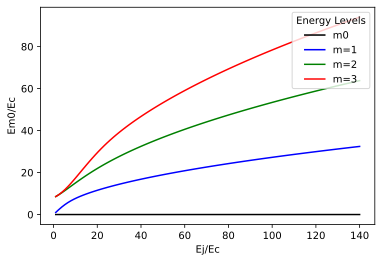

In [110]:
plt.plot(x,E00,'k',label="m0")
plt.plot(x,E10,'b',label="m=1")
plt.plot(x,E20,'g',label="m=2")
plt.plot(x,E30,'r',label="m=3") 
plt.xlabel("Ej/Ec")
plt.ylabel("Em0/Ec")
plt.legend(title="Energy Levels", loc='upper right')

### Anharmonicity

We know that for the transmon qubit, having the Josephson Energy much larger than the charging energy ($E_{J} >> E_{C}$) results in a decrease in anharmonicity. The latter is critical for a functional qubit in which the energy difference between the lowest two states ($E_{01}$) is sufficiently different than the energy difference between the second and third states, $E_{12}$. The absolute anharmonicity is defined as $\alpha = E_{12} - E_{01}$, while the relative anharmonicity is defined as $\alpha_{r} = \alpha/E_{01}$. 

We can easily make a plot of the anharmonicity as a function of $E_{J}/E_{C}$ using the Hcpb class. Let's have the ratio of $E_{J}/E_{C}$ (which we'll call x) vary from 0 to 80, and then we'll create empty lists for $\alpha$ and $\alpha_r$. 

In [111]:
x = np.linspace(0,80,101)   #EJ/EC
alpha = [] 
alpha_r = [] 

Next, we'll just sweep over x and at each value we'll calculate both the absolute and relative anharmonicity. 

In [112]:
for i in x:
    H_anharm = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    alpha.append(H_anharm.anharm()) 
    alpha_r.append(H_anharm.anharm()/H_anharm.fij(0,1))

  after removing the cwd from sys.path.



Note we get a warning here because the relative anharmonicity blows up as Ej/Ec goes to zero. Then we can plot the results:

Text(0, 0.5, 'alpha_r')

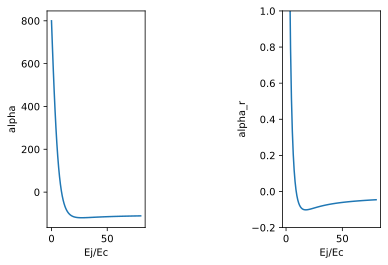

In [113]:
plt.figure(1)
plt.subplot(131)
plt.plot(x,alpha)
plt.xlabel("Ej/Ec")
plt.ylabel("alpha") 
plt.subplot(133)
plt.plot(x,alpha_r)
plt.ylim(-0.2, 1.0) 
plt.xlabel("Ej/Ec")
plt.ylabel("alpha_r")

Indeed we see that the anharmonicity decays with the inverse of $E_{J}/E_{C}$ for small values of $E_{J}/E_{C}$ before reaching a minimum just before $E_{J}/E_{C} \approx 20.0$, then changing sign and approaching zero as $E_{J}/E_{C}$ approaches infinity. This matches very closely to the results found in Figure 5 of Phys. Rev. A 76, 042319 (2007). 

# Qutip simulation 

##### Diagonal Hamiltonian

Wrapper around Qutip to output the diagonalized
Hamiltonian truncated up to n levels of the transmon
for modeling

In [114]:
H.h0_to_qutip(6)

Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[    0.             0.             0.             0.
      0.             0.        ]
 [    0.          3243.38840613     0.             0.
      0.             0.        ]
 [    0.             0.          6378.96041667     0.
      0.             0.        ]
 [    0.             0.             0.          9400.36266124
      0.             0.        ]
 [    0.             0.             0.             0.
  12299.81499693     0.        ]
 [    0.             0.             0.             0.
      0.         15067.4679448 ]]

##### Coupling and number operator
Wrapper around Qutip to output the number operator (charge)
for the Transmon Hamiltonian in the energy eigen-basis.
Used for computing the
coupling between other elements in the system.

In [115]:
H.n_to_qutip(6)

Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[0.00000000e+00 1.42366900e+00 1.05994935e-15 2.86913461e-02
  4.50945885e-16 1.17507132e-03]
 [1.42366900e+00 0.00000000e+00 1.97937812e+00 1.29599460e-15
  6.00893447e-02 6.90834421e-16]
 [1.00443778e-15 1.97937812e+00 0.00000000e+00 2.37911142e+00
  4.12883712e-15 9.99793854e-02]
 [2.86913461e-02 1.26823903e-15 2.37911142e+00 0.00000000e+00
  2.69002748e+00 3.83524102e-15]
 [4.50945832e-16 6.00893447e-02 4.12883712e-15 2.69002748e+00
  0.00000000e+00 2.93638556e+00]
 [1.17507132e-03 6.90834420e-16 9.99793854e-02 3.83545785e-15
  2.93638556e+00 0.00000000e+00]]

# Experimental  

Let's use the "params_from_spectrum" function to calculate the target Ej and Ec values for a desired transmon frequency and anharmonicity. We'll use values of Ej=13971.3 MHz and Ec=295.2 MHz. 

In [116]:
# 13971.3, Ec=295.2
ω, α = 5431, -341
EjEc = H.params_from_spectrum(ω, α) # set self.Ej, Cj
print(EjEc)
print("transmon frequency:", H.fij(0,1), "anharmonicity:", H.anharm())


[13952.97584426   295.61920264]
transmon frequency: 5431.003285965414 anharmonicity: -340.9980226844036


We can also calculate the value of Ej given the value of Ec and the transmon frequency:

In [117]:
Ej = H.params_from_freq_fixEC(ω, 295.17)
print("Ej:", Ej)

Ej: 14424.680512350775


We see that this is close to the starting vaue of 13971.3 MHz that we began with. 

# New section on integrating sc_qubits. 

This section is in development. 

In [ ]:
import scqubits as scq

In [ ]:
qubit = scq.Transmon(
    EJ=13.97124102543,
    EC=0.295179,
    ng=0.001,
    ncut=40,
    truncated_dim=4     # after diagonalization, we will keep 3 levels
)
evals = qubit.eigenvals(evals_count=12)
print(f"freq = {(evals[1] - evals[0])* 1000:.0f} MHz")
print(f"alpha = {((evals[2] - evals[1]) - (evals[1] - evals[0]))* 1000:.0f} MHz")

In [ ]:
qubit.plot_n_wavefunction()
qubit.plot_phi_wavefunction(which=[0,1,2], mode='real')
qubit.hamiltonian()

In [ ]:
import numpy as np
ng_list = np.linspace(-2, 2, 220)
qubit.plot_evals_vs_paramvals('ng', ng_list, evals_count=6, subtract_ground=False);

# Transmon and the Oscillator

This section is currently in development. 